In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("notebooks/split_models", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from config import Config
from data.dataset import NetworkDataset, load_datasets
from utils.plot import plot_precision_recall_f1, plot_fpr_tpr_roc_auc, plot_loss
from model_config import CNN_models, MLP_Models, LSTM_Models, GRU_Models
from model.copy_param import copy_batch_norm, copy_linear_layers, copy_lstm_layers, copy_conv_layers, dpu_copy_model, host_copy_model

In [2]:
conf = Config()
load_models = MLP_Models()
split_conf = load_models.split_mlp_3
model_conf = load_models.mlp_4
split_model = load_models.get_model(split_conf)
model = load_models.get_model(model_conf)
model.load()

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/large_model/mlp_4.pth!


In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_datasets(conf.datasets, load_models.type)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, conf.batch_size, shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, conf.batch_size, shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, conf.batch_size)

In [4]:
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)

torch.Size([512, 513]) torch.Size([512])


In [ ]:
# copy parameters from model to split model
split_idx = split_conf["split_idx"]
dpu_model = split_model.model.dpu_model
host_model = split_model.model.host_model

split_model.model.dpu_model = dpu_copy_model(model.model, dpu_model)
split_model.model.host_model = host_copy_model(model.model, host_model, split_idx, type=load_models.type)

In [6]:
loss, metrics = split_model.evaluate(test_loader)
print(f"Macro-F1 score: {metrics['f1_macro']:.2f}, Micro-F1 score: {metrics['f1_micro']:.2f}, Macro ROC AUC score: {metrics['roc_auc_macro']:.2f}")

Macro-F1 score: 0.68, Micro-F1 score: 0.91, Macro ROC AUC score: 0.97


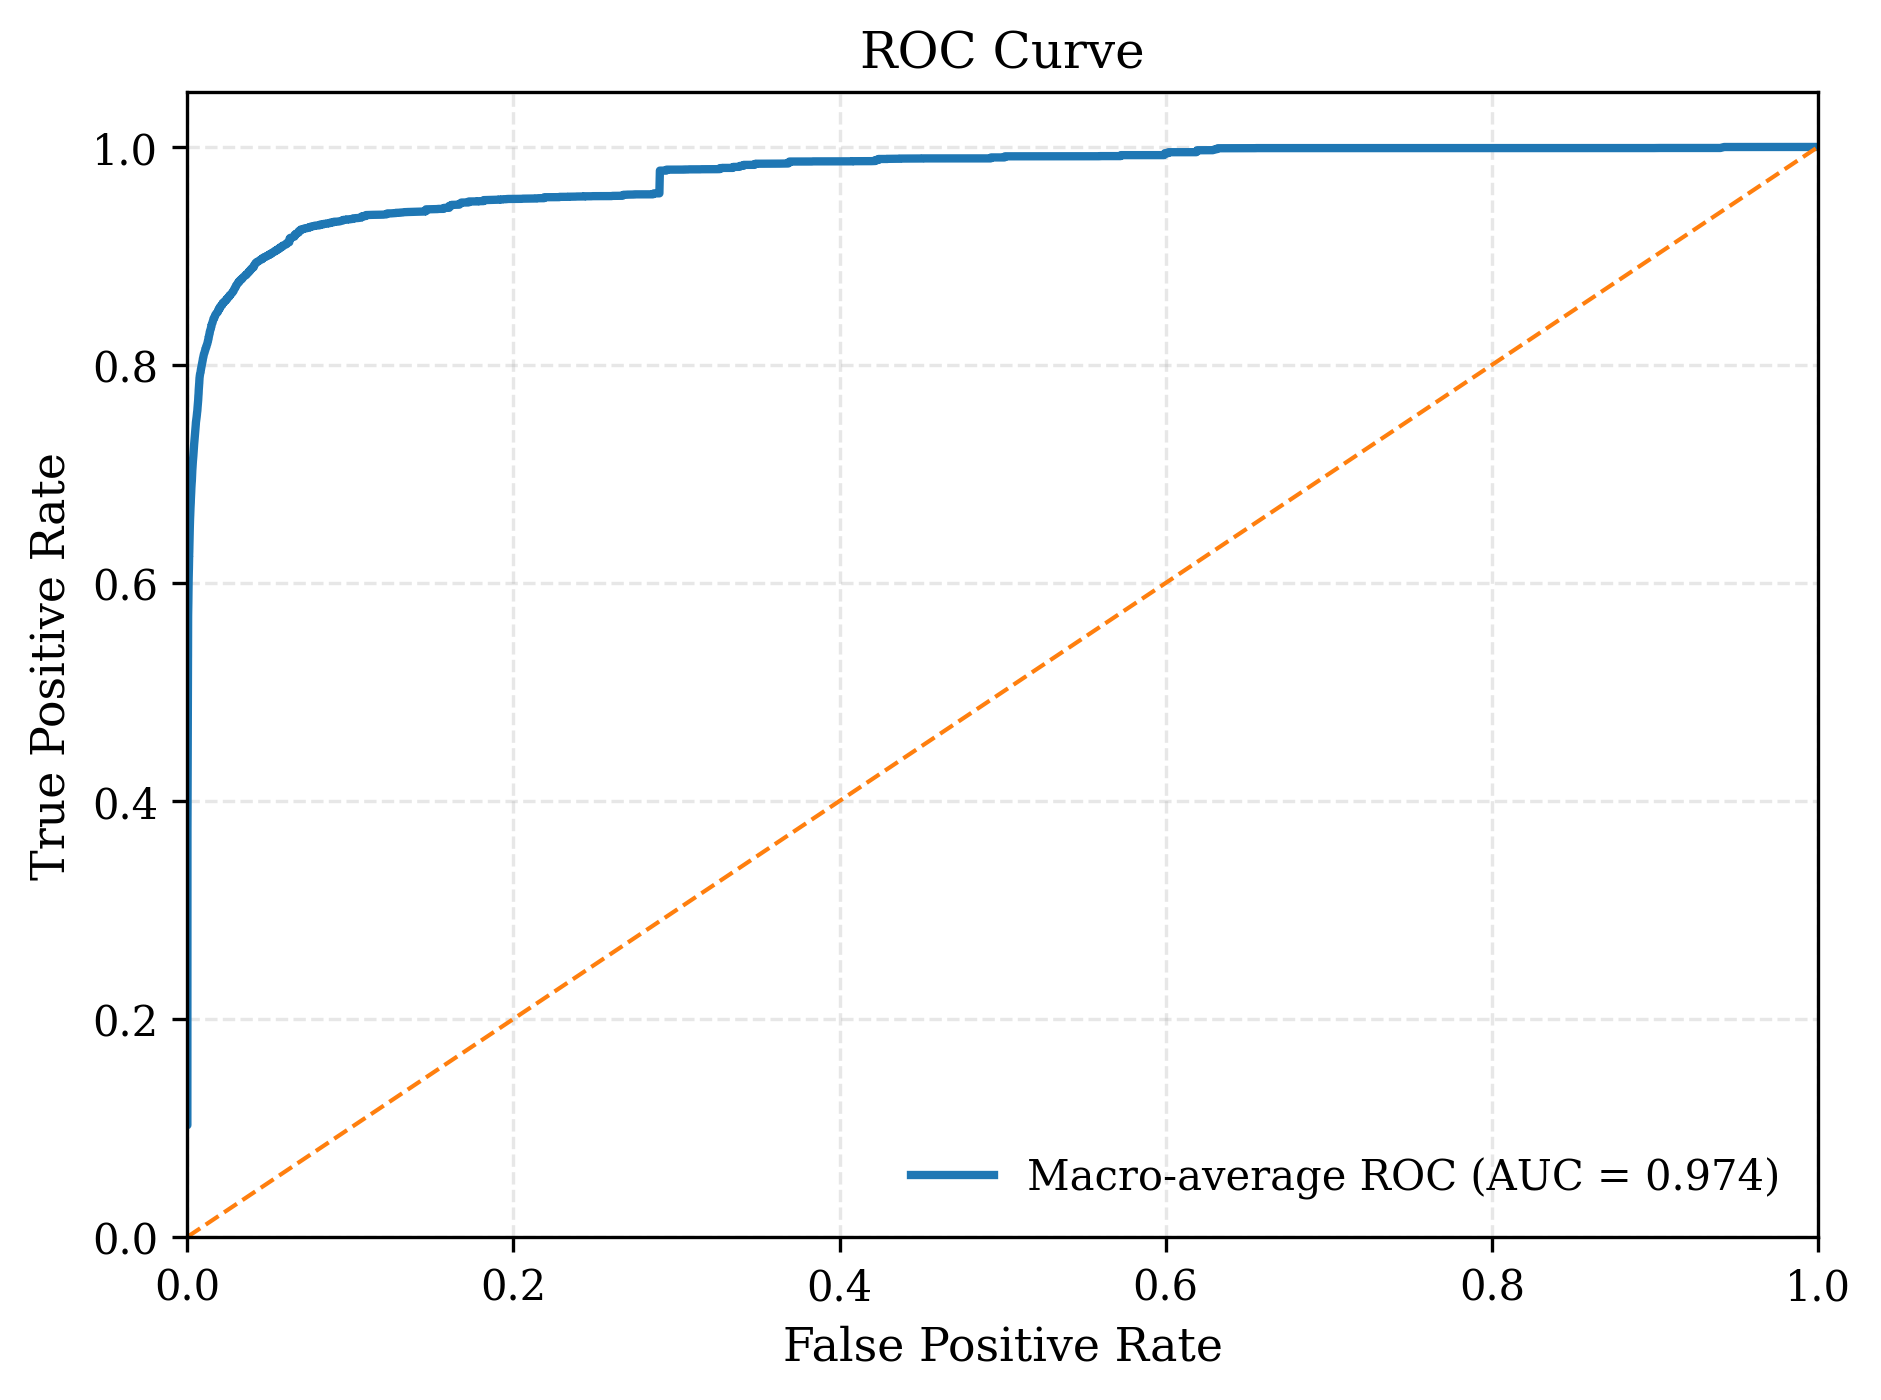

In [7]:
#model.save()
roc_auc_path = os.path.join(os.getcwd().replace("notebooks/split_models", ""), "plots", "training", "roc_auc_" + split_conf["name"] + ".png")
plot_fpr_tpr_roc_auc(metrics, roc_auc_path)